<h1>Assignment 1 Notebook</h1>

<p>This is a Jupyter Notebook created to accompany the first assignment submission for BME495 Deep learning. This notebook is meant to be a bit more functional than the actual assignment and give a bit more flexibility so that I can do some fun things like verbally choose images I want and convolution kernels that I want for them. So with that let's hop in.</p>

<h3>Imports</h3>

<p>The main important imports here (at least for my fledgling deep learning knowledge) is going to be torch and time to see how long torch things take to happen.</p>

In [1]:
import time
import math

import numpy as np
import matplotlib.pyplot as plt

import torch

import PIL

%matplotlib inline

<h3>Image Loading</h3>

<p>We're going to create a function that just takes an image path and then returns both a black and white and a colored version of the image after displaying the image. This will make it way easier for us to import images later. My thinking for now is going to be to create a list of filepaths that I can change or add to and then iterate through those, running this function to create a set of images that I want convolved.</p>

In [2]:
def get_image(filepath):
    original_image = PIL.Image.open(filepath)
    black_and_white = original_image.convert('L')
    
    fig = plt.figure(figsize=(10,10))
    fig.add_subplot(121)
    plt.imshow(original_image)
    plt.title('Original Loaded Image')
    plt.axis('off')
    
    fig.add_subplot(122)
    plt.imshow(black_and_white)
    plt.title('Black and White Image')
    plt.axis('off')
   
    plt.show()
    
    return [original_image, black_and_white]

<h3>Class Creation</h3>

<p>Since we're creating this class within a Jupyter Notebook we lose some of the cross-script functionality that we get by making a conv.py script, however we can accomplish the same goals and instantiate this class throughout our notebook just like we would if we were to import the class definitions from another script.</p>

<p>The main differences between this notebook's Conv2D class and the one defined in conv.py is a difference in inputs. This notebook only takes in_channel, o_channel, stride, and mode, compared to conv.py which also specifies kernel_size. The reason for this was so that I could make a bit of an easier process performing a convolution in favor of a bit of an easier user experience. I've also removed the task argument to the class because it's very specific to this homework assignment for BME495, and in other instances of convolving an image it would be useless.</p>

<p>When you invoke an instance of this class now, the in_channel, o_channel, and stride arguments remain the same, however mode now takes a string argument to verbally describe what the kernel should do. We have a list of kernels defined in the class such as horizontal_edge_kernel and others that can be invoked with prompted types of convolutions below.</p>

In [3]:
class Conv2D(object):

    def __init__(self, in_channel, o_channel, stride, mode):
        self.in_channel = in_channel
        self.o_channel = o_channel
        self.stride = stride
        self.mode = mode

    def forward(self, input_image):

        # Set up kernels
        kernels = []

        horizontal_edge_kernel = torch.tensor([
            [-1, -1, -1], 
            [ 0, 0, 0], 
            [1, 1, 1]
        ])
        vertical_edge_kernel = torch.tensor([
            [-1, 0, 1], 
            [-1, 0, 1], 
            [-1, 0, 1]
        ])
        whiten_kernel = torch.tensor([
            [1, 1, 1], 
            [1, 1, 1], 
            [1, 1, 1]
        ])
        edge_detect_kernel = torch.tensor([
             [-1, -1, -1],
             [-1,  8, -1],  
             [-1, -1, -1]
        ])
        sharpen_kernel = torch.tensor([
            [0, -1, 0],
            [-1, 5, -1],
            [0, -1, 0]
        ])
       
        num_kernels = self.o_channel

        if self.mode == 'rand':
            kernel_size = 5
            for i in range(0,num_kernels):
                kernels.append(torch.randint(-10, 10, (kernel_size, kernel_size)))
        elif self.mode == 'horizontal_edges':
            kernel_size = 3
            for i in range(0,num_kernels):
                kernels.append(horizontal_edge_kernel)
        elif self.mode == 'vertical_edges':
            kernel_size = 3
            for i in range(0,num_kernels):
                kernels.append(vertical_edge_kernel)
        elif self.mode == 'edges':
            kernel_size = 3
            for i in range(0,num_kernels):
                kernels.append(edge_detect_kernel)
        elif self.mode == 'whiten':
            kernel_size = 3
            for i in range(0,num_kernels):
                kernels.append(whiten_kernel)
        elif self.mode == 'sharpen':
            kernel_size = 3
            for i in range(0,num_kernels):
                kernels.append(sharpen_kernel)

        # Convert image object to tensor
        image_array = np.array(input_image)
        image_tensor = torch.from_numpy(image_array)
        dimensions_list = list(image_tensor.shape)
       
        padding = int((kernel_size) / 2)

        if self.in_channel > 1:
            padded_tensor = torch.zeros(dimensions_list[0] + padding, dimensions_list[1] + padding, dimensions_list[2])
            padded_tensor[1:dimensions_list[0]+1, 1:dimensions_list[1]+1, :] = image_tensor
        else:
            padded_tensor = torch.zeros(dimensions_list[0] + padding, dimensions_list[1] + padding)
            padded_tensor[1:dimensions_list[0]+1, 1:dimensions_list[1]+1] = image_tensor

        num_rows = dimensions_list[0]
        num_cols = dimensions_list[1]

        output_rows = int((num_rows - kernel_size + 2*padding) / self.stride + 1)
        output_cols = int((num_cols - kernel_size + 2*padding) / self.stride + 1)

        print("Input image resolution: %dx%d.\n" % (num_rows, num_cols), end="", flush=True)

        # Setting up the output array
        output_tensors = [torch.zeros(output_rows, output_cols) for x in kernels]
        num_operations = [0 for x in kernels]

        for i in range(0,num_kernels):
            print("\nKernel: ")
            print(kernels[i])
            print("\nCurrent kernel number: %d" % (i+1))
            for channel in range(0,self.in_channel):
                print("Current input channel: %d" % (channel+1))
                half_kernel = math.floor(kernel_size / 2)
                # Iterate through each row of the image (outer loop -- y)
                row_out = 0
                for row in range(half_kernel, num_rows-half_kernel, self.stride):
                    # Iterate through each column of the image (inner loop -- x)
                    col_out = 0
                    for col in range(half_kernel, num_cols-half_kernel, self.stride): 
                        num_operations[i] = num_operations[i] + kernel_size + kernel_size-1

                        if self.in_channel > 1:
                            region_of_interest = padded_tensor[row-half_kernel:row+half_kernel+1, col-half_kernel:col+half_kernel+1, channel]    
                        else:
                            region_of_interest = padded_tensor[row-half_kernel:row+half_kernel+1, col-half_kernel:col+half_kernel+1]    
                        
                        region_of_interest = region_of_interest.double()
                        kernel = kernels[i].double()

                        output_tensors[i][row_out, col_out] = output_tensors[i][row_out, col_out] + torch.tensordot(region_of_interest, kernel)
                        
                        col_out = col_out + 1
                    row_out = row_out + 1

        output_tensors = [torch.clamp(output_tensor, min=0, max=255) for output_tensor in output_tensors]

        return [num_operations, output_tensors]

<h3>Tensor Converter Function</h3>

<p>You'll notice that the output of the forward() method for our Conv2D class above is a list of tensors along with number of operations that were performed by the forward() method. For a given input there might be several output images depending on how many kernels you want to use, so we make it output_tensors instead of just output_tensor. Since this tensor doesn't do us a lot of phsyical good we have to actually convert it back to an image and save it to our machine. The function below makes this a lot quicker of a process than manually converting every time.</p>

In [4]:
def tensors_to_images(tensors, conv2d, output_name):

    conv_result_images = []

    # Take the returned tensor convolution result and turn it into an image.
    # A user-defined function would be super useful for this but the instructions
    # don't mention any functions other than main being allowed for this file
    for i, tensor in enumerate(tensors):
        # Normalize the convolution output tensor to a 0-1 scale
        tensor = (tensor - torch.min(tensor)) / (torch.max(tensor) - torch.min(tensor))

        # Convert the tensor to a numpy array and then normalize to 0-255 scale
        numpy_result = tensor.numpy()
        numpy_result = numpy_result * 255
        
        # Convert the numpy array to a PIL image and then convert it to black and white
        conv_result_images.append(PIL.Image.fromarray(numpy_result))
        conv_result_images.append(conv_result_images[-1].convert('RGB'))

        # Save the resultant image as a png image file
        conv_result_images[-1].save('results/'+output_name+'.png', 'PNG')
        print('Convolution image saved as results/'+output_name+'.png')
        plt.figure(figsize=(10,10))
        plt.imshow(conv_result_images[-1])
        plt.axis('off')
        plt.title('Resultant Image')
    
    return conv_result_images

<h3>Image Loading</h3>

<p>Let's grab some images from our machine that we're going to convolve.</p>

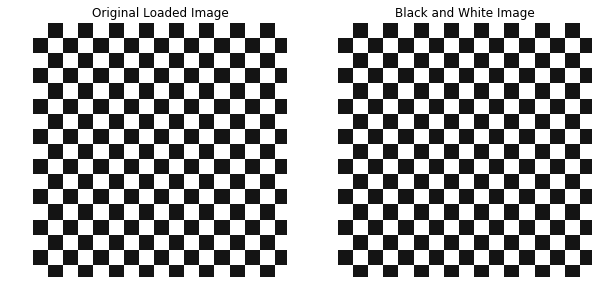

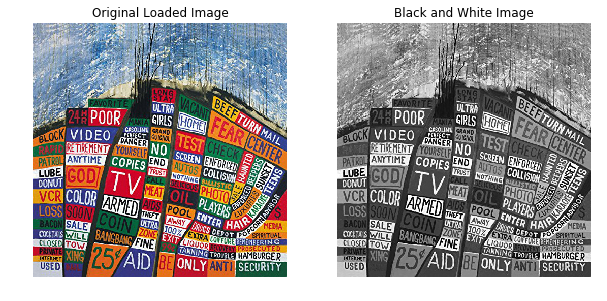

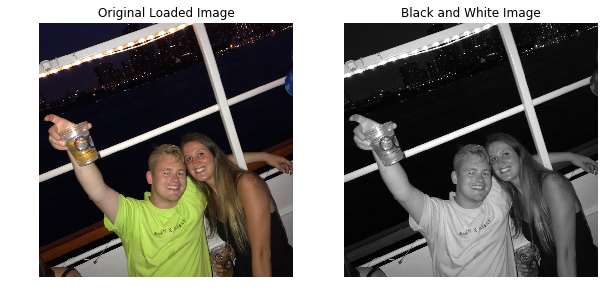

In [5]:
provided_path = 'images/checkerboard.png'
[checkerboard, checkerboard_bw] = get_image(provided_path)
output_name_provided = 'checkerboard_horizontal'

personal_path = 'images/HTTT.jpg'
[thief, thief_bw] = get_image(personal_path)
output_name_personal = 'thief_edges'

ben_path = 'images/ben.jpeg'
[ben, ben_bw] = get_image(ben_path)
output_name_ben = 'ben_edges'

<h3>Conv2D Instantation</h3>

<p>Let's provide the class with all of the arguments we want for a given image and give specific names to each. I create two here with the main difference being the ability to handle a black and white or a colored image, but creating more that would have different kernels to convolve the image with would work just as well here.</p>

<h4>Possible Mode Arguments:</h4>
<ul>
    <li>horizontal_edges</li>
    <li>vertical_edges</li>
    <li>edges</li>
    <li>sharpen</li>
</ul>

In [6]:
conv2d_bw_input = Conv2D(
    in_channel=1,
    o_channel=1,
    stride=1,
    mode='horizontal_edges'
)

conv2d_color_input = Conv2D(
    in_channel=3,
    o_channel=1,
    stride=1,
    mode='sharpen'
)

conv2d_edges = Conv2D(
    in_channel=3,
    o_channel=1,
    stride=1,
    mode='edges'
)

<h3>Convolution Time</h3>

<p>What we've all been waiting for, let's enact that forward method on both classes!</p>

Input image resolution: 420x420.

Kernel: 
tensor([[-1, -1, -1],
        [ 0,  0,  0],
        [ 1,  1,  1]])

Current kernel number: 1
Current input channel: 1
Convolution image saved as results/checkerboard_horizontal.png


[<PIL.Image.Image image mode=F size=420x420 at 0x11AC69748>,
 <PIL.Image.Image image mode=RGB size=420x420 at 0x127EFEEB8>]

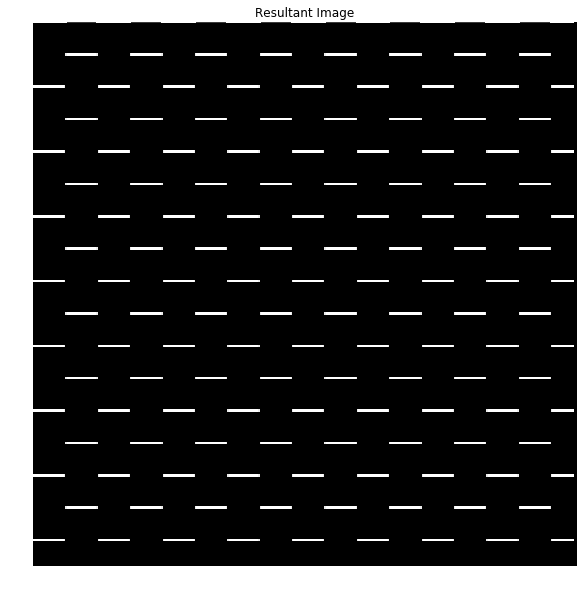

In [7]:
[num_operations, output_tensors] = conv2d_bw_input.forward(checkerboard_bw)
tensors_to_images(output_tensors, conv2d_bw_input, output_name_provided)

Input image resolution: 500x500.

Kernel: 
tensor([[ 0, -1,  0],
        [-1,  5, -1],
        [ 0, -1,  0]])

Current kernel number: 1
Current input channel: 1
Current input channel: 2
Current input channel: 3
Convolution image saved as results/thief_edges.png


[<PIL.Image.Image image mode=F size=500x500 at 0x11AE91710>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x11AE78EB8>]

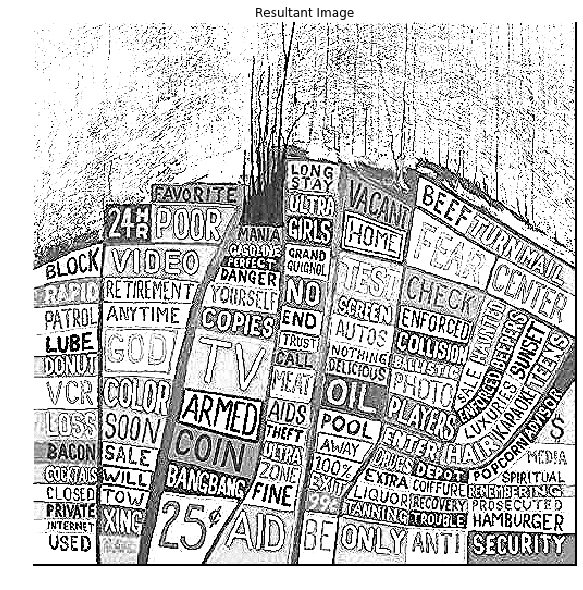

In [8]:
[num_operations, output_tensors] = conv2d_color_input.forward(thief)
tensors_to_images(output_tensors, conv2d_color_input, output_name_personal)

Input image resolution: 1024x1023.

Kernel: 
tensor([[-1, -1, -1],
        [-1,  8, -1],
        [-1, -1, -1]])

Current kernel number: 1
Current input channel: 1
Current input channel: 2
Current input channel: 3
Convolution image saved as results/ben_edges.png


[<PIL.Image.Image image mode=F size=1023x1024 at 0x11AE58048>,
 <PIL.Image.Image image mode=RGB size=1023x1024 at 0x11AE3FC50>]

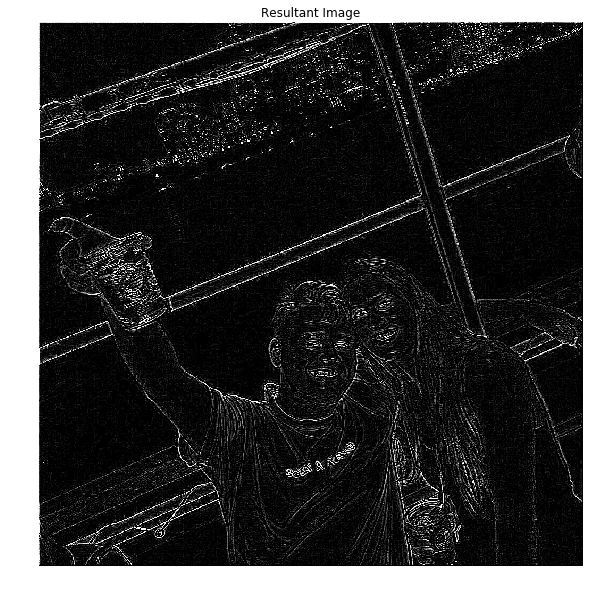

In [9]:
[num_operations, output_tensors] = conv2d_edges.forward(ben)
tensors_to_images(output_tensors, conv2d_color_input, output_name_ben)